# Clasificador Frutas Segunda aproximacion al codigo Aproximaciones Al Codigo
## Tecnicas IA
### Universidad Nacional de Colonbia

1.   Daniel Andres Rojas Paredes
2.   Luis Alberto Chavez Castro



#### 2022-2



In [ ]:
# Librerías
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage.morphology as m
import glob
import PIL
#import scipy.misc
from scipy.signal import convolve2d as conv2
from skimage import data, io, filters
from skimage.morphology import skeletonize
from skimage.filters import threshold_multiotsu as mot


##### Matplotlib:Libreria de trazado de graficos 2d al usar el modul pyplot se pueden usar graficas con configuraciones similares a las de matlab el manejo de matricez lo hace en el formato Numpy
##### Numpy: Permite todo el calculo de matricez
##### PIL:Libreria de manejo y procesamiento de imagenes El módulo Imagen proporciona una clase con el mismo nombre que se utiliza para representar una imagen PIL. El módulo también proporciona una serie de funciones de fábrica, incluidas funciones para cargar imágenes desde archivos y para crear nuevas imágenes.
##### Scipy: ofrece un entorno similar al de matlab y a travez del paquete ndimage.morphology se pueden realizar operaciones de erocion dilatacion y demas operaciones morfologicas en imagenes ndimencionales , con el modulo signal  se pueden realizar diferentes operaciones del procesamiento de señales basico
#####Skimage: es un conjunto de algorithmos para el procesamiento de imagen el modulo de filtros posee operaciones como Nitidez, búsqueda de bordes, filtros de rango, umbralización, etc. el de io  permite Leer, guardar y mostrar imágenes y videos. y el modulo data tiene ejemplos y testeos

####Libreria Glob se usa para especificar los paths atravez de la funcion glob puedo obtener una lista d todos los archivos de donde se ejecuta el kernel espesificando un comando espesifico de manera muy similar a como se aria en linux


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importo librerias de pythoch e instancio RED NEURONAL**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F #capas sin parametros

In [ ]:
#una red se monta como una clase que hereda de nn.module
# en el metdo init como atributos van todas las capas con pareametros que deben ser entrenadas
# en el metodo fordware van todas las capas
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net,self).__init__()

    self.num_channels = num_channels

    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)

    self.fc1 = nn.Linear(self.num_channels*4*32*32, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 3)

  def forward(self,x):
      #Empieza 3x512x512
      x = self.conv1(x) # num_channels x 512x512
      x = F.relu(F.max_pool2d(x, 2)) # num_channels x 256x256
      x = self.conv2(x) # num_channels*2 x 256x256
      x = F.relu(F.max_pool2d(x, 2)) #num_channels*2 x 128x128
      x = self.conv3(x) # num_channels*4 x128x128
      x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 64x64

      #flatten
      x = x.view(-1, self.num_channels*4*32*32)

      #fc
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)

      #log_softmax

      x = F.log_softmax(x, dim=1)

      return x

**Carga Dataset Resize de las imagenes**

In [ ]:

MainDir="/content/drive/Shareddrives/TIA/DATASET/Training/"
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms  as transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.transforms import Resize


Conjunto de entrenamiento: se utiliza para entrenar el modelo, es decir, calcular la pérdida y ajustar los pesos del modelo mediante descenso de gradiente.
Conjunto de validación: se utiliza para evaluar el modelo durante el entrenamiento, ajustar los hiperparámetros (tasa de aprendizaje, etc.) y elegir la mejor versión del modelo.
Conjunto de prueba: se utiliza para comparar diferentes modelos o diferentes tipos de enfoques de modelado e informar la precisión final del modelo. Dado que no hay un conjunto de validación predefinido, podemos reservar una pequeña parte (alrededor del 10% del conjunto de datos de entrenamiento) para usar como conjunto de validación. Usaremos el método auxiliar random_split de PyTorch para hacer esto. Para asegurarnos de crear siempre el mismo conjunto de validación, también estableceremos una semilla para el generador de números aleatorios

In [ ]:
# SE AJUSTA LAS IMAGENES A UN MISMO TAMAÑO TODAS PARA PODER TRA
#KEAR EL TAMAÑO DEL TENSOR ESTO TAMBIEN FUNCIONA COMO REGULARIZACION EN CUANTO SE AUM
#MENTA LA CANTIDAD DE NEURONAS?
settingData =transforms.Compose ([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),# Normalizacion
    ])
Data = ImageFolder(MainDir + '/Tangerinne', transform=settingData)
print('Size of training dataset :', len(Data))


Size of training dataset : 505


torch.Size([3, 256, 256])
0


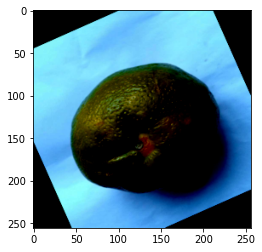

In [ ]:
# view one image shape of the dataset.
img, label = Data[5]
print(img.shape)
print(label)
plt.imshow(img.permute(1, 2, 0))



In [ ]:
#DATALOADERS
validation,test,train=torch.utils.data.random_split(Data, [40, 40,len(Data)-80], generator=torch.Generator( ).manual_seed(42))
batch_size = 32
train_loader = DataLoader(train, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size, num_workers=4, pin_memory=True)
Validation_loader = DataLoader(validation, batch_size, num_workers=4, pin_memory=True)
loaders = {'train':train_loader,'test':test_loader,'val':Validation_loader}



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid
grid=0
for inputs, targets in Validation_loader:
  grid = make_grid(inputs)
  print(targets)
  break
img = transforms.ToPILImage()(grid)

tensor([2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 1, 2, 0, 2, 0, 1,
        0, 1, 2, 1, 2, 0, 1, 1])


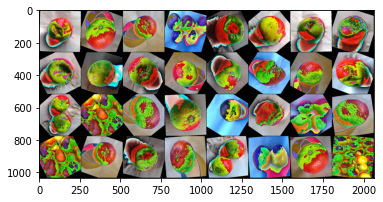

In [ ]:
plt.imshow(img)

**OPTIMIZACION y definicion de metricas**


In [ ]:
##INSTANCIO CLASE DE METRICAS
#ETA FUNCION CORRE LOS 3 METODOS XADA QUE ES LLAMADA?
#HACE IN PROMEDIO DE s
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0

  def update(self, val, size):
    self.S += val
    self.N += size

  def __call__(self):
    return self.S/float(self.N)

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
device = torch.device('cuda')
device

device(type='cuda')

Que es y quehace un optimizador.

El learning rates solia ser escogido a mano , sin embargo este proceso es bastante tedioso, asi que se han desarrollado algorithmos para la escogencia de este learning rate  llamados optimisadores adaptativos (adagrad, adadelta,adam) que estan basados en el Stochastic gradient desent.  que es el optiizador que usaremos

In [ ]:
net = Net(32).to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)

**GRAFICADORES DE METRICAS**

EPOCHS LOPOP DE ENTRENAMIENTO

In [ ]:
num_epochs = 50
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/Bannanas_trainer_{}'.format(timestamp),flush_secs=120)

In [ ]:

for epoch in range(num_epochs):
 # print('Epoch {}/{}'.format(epoch+1, num_epochs))
  #print('-'*10)

  running_loss = RunningMetric() # perdida
  running_acc = RunningMetric() #precision

  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    #Calcular los gradienes de la funcion de costo respecto a los paramentros
    #actualizar los parametros con dichos gradientes
    #pytorch acumula el gradiente, no es deseado, debe ser reiniciado en 0
    optimizer.zero_grad()

    outputs = net(inputs)#  batch.size filas por 3 columnas
    _, preds = torch.max(outputs,1) #para cada fila devuelve el maximo de las columnas
    #preds se refiere al indice de ese valor
    loss = loss_fn(outputs, targets)

    loss.backward() #back propagation
    optimizer.step() #learning rate con S gradient desent

    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size,
                       batch_size) #se actualiza el promedio ponderado de la perdida segun el batch
    running_acc.update(torch.sum(preds == targets).float(), #De los 32 cuantos predijo bien
                       batch_size)
    writer.add_scalar('Loss/train', running_loss(), num_epochs)
    writer.add_scalar('accus/train',running_acc(), num_epochs)
  print("Loss: {:.4f} Acc: {:.4f} ".format(running_loss(),
                                          running_acc()))


Loss: 1.0832 Acc: 0.4165 
Loss: 1.0473 Acc: 0.4353 
Loss: 1.0121 Acc: 0.4353 
Loss: 0.9664 Acc: 0.4706 
Loss: 0.8848 Acc: 0.4965 
Loss: 0.7592 Acc: 0.7741 
Loss: 0.6033 Acc: 0.8518 
Loss: 0.4605 Acc: 0.8635 
Loss: 0.3423 Acc: 0.9082 
Loss: 0.2536 Acc: 0.9247 
Loss: 0.2376 Acc: 0.9224 
Loss: 0.1823 Acc: 0.9294 
Loss: 0.1906 Acc: 0.9294 
Loss: 0.1378 Acc: 0.9600 
Loss: 0.1091 Acc: 0.9576 
Loss: 0.0937 Acc: 0.9718 
Loss: 0.1125 Acc: 0.9624 
Loss: 0.1433 Acc: 0.9482 
Loss: 0.1118 Acc: 0.9529 
Loss: 0.0851 Acc: 0.9647 
Loss: 0.0563 Acc: 0.9906 
Loss: 0.0520 Acc: 0.9882 
Loss: 0.0440 Acc: 0.9906 
Loss: 0.0390 Acc: 0.9906 
Loss: 0.0341 Acc: 0.9976 
Loss: 0.0281 Acc: 0.9976 
Loss: 0.0609 Acc: 0.9812 
Loss: 0.1222 Acc: 0.9482 
Loss: 0.1563 Acc: 0.9482 
Loss: 0.0505 Acc: 0.9835 
Loss: 0.0233 Acc: 1.0000 
Loss: 0.0185 Acc: 1.0000 
Loss: 0.0168 Acc: 1.0000 
Loss: 0.0142 Acc: 1.0000 
Loss: 0.0124 Acc: 1.0000 
Loss: 0.0130 Acc: 1.0000 
Loss: 0.0116 Acc: 1.0000 
Loss: 0.0094 Acc: 1.0000 
Loss: 0.0090

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
notebook.display(port=6006, height=1000)

In [ ]:
#plot_losses(loss_history)
#plot_accuracies(acu_history)

**REGULARIZACIÓN**


In [ ]:
#aumentar el dataset virtualmente y normalizar con campana gauciana
Regularizacion =transforms.Compose ([
        transforms.RandomHorizontalFlip,#aumentation
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),# Normalizacion
    ])

In [ ]:
#una red se monta como una clase que hereda de nn.module
# en el metdo init como atributos van todas las capas con pareametros que deben ser entrenadas
# en el metodo fordware van todas las capas
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net,self).__init__()

    self.num_channels = num_channels

    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding = 1)
    self.bn1=nn.BatchNorm2d(self.num_channels)# batch normalization para cada capa de la red
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.bn2=nn.BatchNorm2d(self.num_channels*2)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)
    self.bn3=nn.BatchNorm2d(self.num_channels*4)

    self.fc1 = nn.Linear(self.num_channels*4*32*32, self.num_channels*4)
    self.fcbn1=nn.BatchNorm1d(self.num_channels*4)# es 1d porque aca el tensor es un arreglo no una imagen se aplano
    self.fc2 = nn.Linear(self.num_channels*4, 3)

  def forward(self,x):
      #Empieza 3x512x512
      x = self.bn1(self.conv1(x)) # num_channels x 512x512
      x = F.relu(F.max_pool2d(x, 2)) # num_channels x 256x256
      x = self.bn2(self.conv2(x)) # num_channels*2 x 256x256
      x = F.relu(F.max_pool2d(x, 2)) #num_channels*2 x 128x128
      x = self.bn3(self.conv3(x)) # num_channels*4 x128x128
      x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 64x64

      #flatten
      x = x.view(-1, self.num_channels*4*32*32)##????

      #fc
      x = F.relu(self.fcbn1(self.fc1(x)))
      x = F.dropout(x,p=0.8,training=True)#Dropout
      x = self.fc2(x)

      #log_softmax

      x = F.log_softmax(x, dim=1)

      return x

OPTIMIZACION DE HIPERPARAMETROS  POR RANDOM SEARCH SI AY TIEMPO SI NO POR LA GERARQUIA DE ANDREW NG

In [ ]:
historial_training=[]
historial_val=[]

In [ ]:
def T_and_E(model,optimizer,loss_fn,dataloader,device,num_epochs=10,lr=0.0001):
  for g in optimizer.param_groups:
    g['lr']=lr
    print("lrs{} : ".format(lr))
  for epoch in range(num_epochs):
    #print('Epoch {}/{}'.format(epoch+1, num_epochs))
    #print('-'*10)

    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      running_loss = RunningMetric() # perdida
      running_acc = RunningMetric() #precision

      for inputs, targets in loaders[phase]:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase=='train'):
          #calculo la perdida
          outputs = net(inputs)
          _, preds = torch.max(outputs,1)
          loss = loss_fn(outputs, targets)
          if phase=='train':

            loss.backward() #back propagation
            optimizer.step() #learning rate con S gradient desent

        batch_size = inputs.size()[0]
        running_loss.update(loss.item()*batch_size,
                          batch_size)
        running_acc.update(torch.sum(preds == targets).float(),
                          batch_size)
     # print("Loss: {:.4f} Acc: {:.4f} ".format(running_loss(),
             #                                 running_acc()))
      print("Loss{}: {:.4f} Acc{}: {:.4f} ".format(phase,
      running_loss(),
      phase,
      running_acc()))
  return model


In [ ]:
net = Net(32).to(device)
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)
num_epochs = 10

segmentacion

In [ ]:
T_and_E (net,optimizer,loss_fn,loaders,device,num_epochs,1e-6)

lrs1e-06 : 
Losstrain: 1.2059 Acctrain: 0.3963 
Lossval: 1.1254 Accval: 0.4750 
Losstrain: 1.0834 Acctrain: 0.4603 
Lossval: 1.0492 Accval: 0.5250 
Losstrain: 1.0091 Acctrain: 0.5103 
Lossval: 0.8658 Accval: 0.6250 
Losstrain: 0.9470 Acctrain: 0.5471 
Lossval: 1.0588 Accval: 0.4500 
Losstrain: 0.8839 Acctrain: 0.5946 
Lossval: 0.9189 Accval: 0.5250 
Losstrain: 0.8291 Acctrain: 0.6303 
Lossval: 1.0220 Accval: 0.4250 
Losstrain: 0.7946 Acctrain: 0.6531 
Lossval: 0.8830 Accval: 0.5500 
Losstrain: 0.7625 Acctrain: 0.6738 
Lossval: 0.8353 Accval: 0.5500 
Losstrain: 0.7216 Acctrain: 0.6988 
Lossval: 0.7950 Accval: 0.6250 
Losstrain: 0.6912 Acctrain: 0.7116 
Lossval: 0.6889 Accval: 0.7250 
Losstrain: 0.6758 Acctrain: 0.7225 
Lossval: 0.6594 Accval: 0.7250 
Losstrain: 0.6541 Acctrain: 0.7399 
Lossval: 0.7300 Accval: 0.6250 
Losstrain: 0.6352 Acctrain: 0.7489 
Lossval: 0.7248 Accval: 0.6500 
Losstrain: 0.6201 Acctrain: 0.7573 
Lossval: 0.6909 Accval: 0.7000 
Losstrain: 0.6017 Acctrain: 0.7691 


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fcbn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
import random

lrs=[10**(-4),10**(-5),10**(-6)]#10**(-random.randint(4,6))for _ in range(3)
for lr in lrs :
  T_and_E (net,optimizer,loss_fn,loaders,device,num_epochs,lr)

lrs0.0001 : 
Losstrain: 0.9960 Acctrain: 0.5435 
Lossval: 1.0151 Accval: 0.5000 
Losstrain: 0.5022 Acctrain: 0.8353 
Lossval: 0.7684 Accval: 0.7750 
Losstrain: 0.4672 Acctrain: 0.8541 
Lossval: 0.4473 Accval: 0.9000 
Losstrain: 0.3695 Acctrain: 0.9012 
Lossval: 0.3324 Accval: 0.9500 
Losstrain: 0.3165 Acctrain: 0.9294 
Lossval: 0.3495 Accval: 0.9250 
Losstrain: 0.2938 Acctrain: 0.9341 
Lossval: 0.3483 Accval: 0.9000 
Losstrain: 0.2671 Acctrain: 0.9200 
Lossval: 0.3361 Accval: 0.9250 
Losstrain: 0.2519 Acctrain: 0.9482 
Lossval: 0.3699 Accval: 0.9500 
Losstrain: 0.2671 Acctrain: 0.9459 
Lossval: 0.3011 Accval: 0.9500 
Losstrain: 0.2563 Acctrain: 0.9365 
Lossval: 0.3355 Accval: 0.9250 
lrs1e-05 : 
Losstrain: 0.2121 Acctrain: 0.9600 
Lossval: 0.2787 Accval: 0.9250 
Losstrain: 0.2438 Acctrain: 0.9412 
Lossval: 0.2346 Accval: 0.9500 
Losstrain: 0.2282 Acctrain: 0.9624 
Lossval: 0.2878 Accval: 0.9250 
Losstrain: 0.2334 Acctrain: 0.9553 
Lossval: 0.3210 Accval: 0.9500 
Losstrain: 0.2214 Acctr

In [ ]:
T_and_E (net,optimizer,loss_fn,loaders,device,num_epochs,1e-5)



lrs1e-05 : 
Losstrain: 1.0533 Acctrain: 0.4805 
Lossval: 0.8815 Accval: 0.5500 
Losstrain: 0.7003 Acctrain: 0.7014 
Lossval: 0.5281 Accval: 0.8000 
Losstrain: 0.5449 Acctrain: 0.8048 
Lossval: 0.5496 Accval: 0.8000 
Losstrain: 0.4730 Acctrain: 0.8427 
Lossval: 0.4355 Accval: 0.8250 
Losstrain: 0.4199 Acctrain: 0.8725 
Lossval: 0.4650 Accval: 0.8750 
Losstrain: 0.3923 Acctrain: 0.8884 
Lossval: 0.4833 Accval: 0.8000 
Losstrain: 0.3645 Acctrain: 0.9027 
Lossval: 0.2885 Accval: 0.9000 
Losstrain: 0.3406 Acctrain: 0.9147 
Lossval: 0.2999 Accval: 0.9750 
Losstrain: 0.3155 Acctrain: 0.9262 
Lossval: 0.3475 Accval: 0.9500 
Losstrain: 0.3039 Acctrain: 0.9365 
Lossval: 0.2907 Accval: 0.9250 
Losstrain: 0.2852 Acctrain: 0.9388 
Lossval: 0.2634 Accval: 0.9250 
Losstrain: 0.2748 Acctrain: 0.9380 
Lossval: 0.2523 Accval: 0.9500 


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fcbn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
b=T_and_E (netb,optimizer,loss_fn,loaders,device,num_epochs,1e-07)

### metodo predict para validacion

---https://interactivechaos.com/es/manual/tutorial-de-deep-learning/cuerpo-del-metodo-predict



TensorBoard


In [ ]:
%pip install tensorboard

In [ ]:
%pylab inline
import torch.utils.tensorboard as tb
import tempfile
log_dir=tempfile.mkdtemp()#directorio para guardar logs
#%tensorboard --logdir(log_dir) --reload_interval 1 #reload every 1scd
# al parecer ya no
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

In [ ]:
%tensorboard --logdir=runs

redes convolucionales